In [1]:
# Keras
import keras
from keras import regularizers
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential, Model, model_from_json
from keras.layers import Dense, Embedding, LSTM
from keras.layers import Input, Flatten, Dropout, Activation, BatchNormalization
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from keras.utils import np_utils
from keras.callbacks import (EarlyStopping, LearningRateScheduler,
                             ModelCheckpoint, TensorBoard, ReduceLROnPlateau)
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import optimizers
from keras import losses, models
from keras.activations import relu, softmax
from keras.layers import (Convolution2D, GlobalAveragePooling2D, BatchNormalization, Flatten, Dropout,
                          GlobalMaxPool2D, MaxPool2D, concatenate, Activation, Input, Dense)

# sklearn
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Other  
from tqdm import tqdm, tqdm_pandas
import scipy
from scipy.stats import skew
import pickle
import librosa
import librosa.display
import json
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from matplotlib.pyplot import specgram
import pandas as pd
import seaborn as sns
import glob 
import os
import sys
import IPython.display as ipd  # To play sound in the notebook
import warnings
# ignore warnings 
if not sys.warnoptions:
    warnings.simplefilter("ignore")

## 1. Custom functions 

In [2]:
'''
1. Data Augmentation method   
'''
def speedNpitch(data):
    """
    Speed and Pitch Tuning.
    """
    # you can change low and high here
    length_change = np.random.uniform(low=0.8, high = 1)
    speed_fac = 1.2  / length_change # try changing 1.0 to 2.0 ... =D
    tmp = np.interp(np.arange(0,len(data),speed_fac),np.arange(0,len(data)),data)
    minlen = min(data.shape[0], tmp.shape[0])
    data *= 0
    data[0:minlen] = tmp[0:minlen]
    return data

'''
2. Extracting the MFCC feature as an image (Matrix format).  
'''
def prepare_data(df, n, aug, mfcc):
    X = np.empty(shape=(df.shape[0], n, 216, 1))
    input_length = sampling_rate * audio_duration
    
    cnt = 0
    for fname in tqdm(df.path):
        file_path = fname
        data, _ = librosa.load(file_path, sr=sampling_rate
                               ,res_type="kaiser_fast"
                               ,duration=2.5
                               ,offset=0.5
                              )

        # Random offset / Padding
        if len(data) > input_length:
            max_offset = len(data) - input_length
            offset = np.random.randint(max_offset)
            data = data[offset:(input_length+offset)]
        else:
            if input_length > len(data):
                max_offset = input_length - len(data)
                offset = np.random.randint(max_offset)
            else:
                offset = 0
            data = np.pad(data, (offset, int(input_length) - len(data) - offset), "constant")

        # Augmentation? 
        if aug == 1:
            data = speedNpitch(data)
        
        # which feature?
        if mfcc == 1:
            # MFCC extraction 
            MFCC = librosa.feature.mfcc(data, sr=sampling_rate, n_mfcc=n_mfcc)
            MFCC = np.expand_dims(MFCC, axis=-1)
            X[cnt,] = MFCC
            
        else:
            # Log-melspectogram
            melspec = librosa.feature.melspectrogram(data, n_mels = n_melspec)   
            logspec = librosa.amplitude_to_db(melspec)
            logspec = np.expand_dims(logspec, axis=-1)
            X[cnt,] = logspec
            
        cnt += 1
    
    return X


'''
3. Confusion matrix plot 
'''        
def print_confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=14):
    '''Prints a confusion matrix, as returned by sklearn.metrics.confusion_matrix, as a heatmap.

    Arguments
    ---------
    confusion_matrix: numpy.ndarray
        The numpy.ndarray object returned from a call to sklearn.metrics.confusion_matrix. 
        Similarly constructed ndarrays can also be used.
    class_names: list
        An ordered list of class names, in the order they index the given confusion matrix.
    figsize: tuple
        A 2-long tuple, the first value determining the horizontal size of the ouputted figure,
        the second determining the vertical size. Defaults to (10,7).
    fontsize: int
        Font size for axes labels. Defaults to 14.

    Returns
    -------
    matplotlib.figure.Figure
        The resulting confusion matrix figure
    '''
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")

    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

    
    
'''
# 4. Create the 2D CNN model 
'''
def get_2d_conv_model(n):
    ''' Create a standard deep 2D convolutional neural network'''
    nclass = 14
    inp = Input(shape=(n,216,1))  #2D matrix of 30 MFCC bands by 216 audio length.
    x = Convolution2D(32, (4,10), padding="same")(inp)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = MaxPool2D()(x)
    x = Dropout(rate=0.2)(x)
    
    x = Convolution2D(32, (4,10), padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = MaxPool2D()(x)
    x = Dropout(rate=0.2)(x)
    
    x = Convolution2D(32, (4,10), padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = MaxPool2D()(x)
    x = Dropout(rate=0.2)(x)
    
    x = Convolution2D(32, (4,10), padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = MaxPool2D()(x)
    x = Dropout(rate=0.2)(x)
    
    x = Flatten()(x)
    x = Dense(64)(x)
    x = Dropout(rate=0.2)(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = Dropout(rate=0.2)(x)
    
    out = Dense(nclass, activation=softmax)(x)
    model = models.Model(inputs=inp, outputs=out)
    
    opt = optimizers.Adam(0.001)
    model.compile(optimizer=opt, loss=losses.categorical_crossentropy, metrics=['acc'])
    return model

'''
# 5. Other functions 
'''
class get_results:
    '''
    We're going to create a class (blueprint template) for generating the results based on the various model approaches. 
    So instead of repeating the functions each time, we assign the results into on object with its associated variables 
    depending on each combination:
        1) MFCC with no augmentation  
        2) MFCC with augmentation 
        3) Logmelspec with no augmentation 
        4) Logmelspec with augmentation
    '''
    
    def __init__(self, model_history, model ,X_test, y_test, labels):
        self.model_history = model_history
        self.model = model
        self.X_test = X_test
        self.y_test = y_test             
        self.labels = labels

    def create_plot(self, model_history):
        '''Check the logloss of both train and validation, make sure they are close and have plateau'''
        plt.plot(model_history.history['loss'])
        plt.plot(model_history.history['val_loss'])
        plt.title('model loss')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend(['train', 'test'], loc='upper left')
        plt.show()

    def create_results(self, model):
        '''predict on test set and get accuracy results'''
        opt = optimizers.Adam(0.001)
        model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
        score = model.evaluate(X_test, y_test, verbose=0)
        print("%s: %.2f%%" % (model.metrics_names[1], score[1]*100))

    def confusion_results(self, X_test, y_test, labels, model):
        '''plot confusion matrix results'''
        preds = model.predict(X_test, 
                                 batch_size=16, 
                                 verbose=2)
        preds=preds.argmax(axis=1)
        preds = preds.astype(int).flatten()
        preds = (lb.inverse_transform((preds)))

        actual = y_test.argmax(axis=1)
        actual = actual.astype(int).flatten()
        actual = (lb.inverse_transform((actual)))

        classes = labels
        classes.sort()    

        c = confusion_matrix(actual, preds)
        print_confusion_matrix(c, class_names = classes)
    
    def accuracy_results_gender(self, X_test, y_test, labels, model):
        '''Print out the accuracy score and confusion matrix heat map of the Gender classification results'''
    
        preds = model.predict(X_test, 
                         batch_size=16, 
                         verbose=2)
        preds=preds.argmax(axis=1)
        preds = preds.astype(int).flatten()
        preds = (lb.inverse_transform((preds)))

        actual = y_test.argmax(axis=1)
        actual = actual.astype(int).flatten()
        actual = (lb.inverse_transform((actual)))
        
        # print(accuracy_score(actual, preds))
        
        actual = pd.DataFrame(actual).replace({'female_angry':'female'
                   , 'female_disgust':'female'
                   , 'female_fear':'female'
                   , 'female_happy':'female'
                   , 'female_sad':'female'
                   , 'female_surprise':'female'
                   , 'female_neutral':'female'
                   , 'male_angry':'male'
                   , 'male_fear':'male'
                   , 'male_happy':'male'
                   , 'male_sad':'male'
                   , 'male_surprise':'male'
                   , 'male_neutral':'male'
                   , 'male_disgust':'male'
                  })
        preds = pd.DataFrame(preds).replace({'female_angry':'female'
               , 'female_disgust':'female'
               , 'female_fear':'female'
               , 'female_happy':'female'
               , 'female_sad':'female'
               , 'female_surprise':'female'
               , 'female_neutral':'female'
               , 'male_angry':'male'
               , 'male_fear':'male'
               , 'male_happy':'male'
               , 'male_sad':'male'
               , 'male_surprise':'male'
               , 'male_neutral':'male'
               , 'male_disgust':'male'
              })

        classes = actual.loc[:,0].unique() 
        classes.sort()    

        c = confusion_matrix(actual, preds)
        print(accuracy_score(actual, preds))
        print_confusion_matrix(c, class_names = classes)

In previous post you've seen the visualisation of the MFCC, where it captures all the core information of the audio file into a single image. Well, if an audio information can be interpreted as an image, then surely we can apply the same image recognition approaches like VGG19 or RESNET and the like? 

The answer is yes. And is suprisingly very fast and accurate. Its not as accurate as when applying RNN type models on the audio wave itself. But its very close to its accuracy potential, and heaps faster. There's some assumptions and limitations depending on use cases of course. 

Lets pick up the meta-data file again that has all our file path

In [3]:
ref = pd.read_csv("./datasets/Data_path.csv")
ref.head()

,labels,source,path
0,male_angry,SAVEE,./datasets/SAVEE/DC/a01.wav
1,male_angry,SAVEE,./datasets/SAVEE/DC/a02.wav
2,male_angry,SAVEE,./datasets/SAVEE/DC/a03.wav
3,male_angry,SAVEE,./datasets/SAVEE/DC/a04.wav
4,male_angry,SAVEE,./datasets/SAVEE/DC/a05.wav


<a id="MFCConly"></a>
## 2. MFCC without augmentation
So, what I'm about to do is use the entire MFCC data and treat it as an image, and push it through to a 2D CNN instead of a 1D CNN that we saw in previous parts. This will be without data augmentation for now. The convergence is very quick so instead of letting it run over 50 or more epochs, I'm going to just cut it at 20. 

In [4]:
sampling_rate=44100
audio_duration=2.5
n_mfcc = 30
mfcc = prepare_data(ref, n = n_mfcc, aug = 0, mfcc = 1)

100%|███████████████████████████████████████████████████████████████████████████| 1920/1920 [03:45<00:00,  8.53it/s]


In [5]:
# Split between train and test 
X_train, X_test, y_train, y_test = train_test_split(mfcc
                                                    , ref.labels
                                                    , test_size=0.25
                                                    , shuffle=True
                                                    , random_state=42
                                                   )


# one hot encode the target 
lb = LabelEncoder()
y_train = np_utils.to_categorical(lb.fit_transform(y_train))
y_test = np_utils.to_categorical(lb.fit_transform(y_test))

# Pickel the lb object for future use 
filename = 'labels_2D'
outfile = open('./model/'+filename,'wb')
pickle.dump(lb,outfile)
outfile.close()

# Normalization as per the standard NN process
mean = np.mean(X_train, axis=0)
std = np.std(X_train, axis=0)

X_train = (X_train - mean)/std
X_test = (X_test - mean)/std


In [6]:
# Build CNN model 
model = get_2d_conv_model(n=n_mfcc)
model_history = model.fit(X_train, y_train, validation_data=(X_test, y_test), 
                    batch_size=16, verbose = 2, epochs=30)

Epoch 1/30
90/90 - 36s - loss: 2.5680 - acc: 0.1826 - val_loss: 2.0574 - val_acc: 0.3021 - 36s/epoch - 404ms/step
Epoch 2/30
90/90 - 31s - loss: 2.2271 - acc: 0.2438 - val_loss: 2.2743 - val_acc: 0.2313 - 31s/epoch - 348ms/step
Epoch 3/30
90/90 - 31s - loss: 2.1307 - acc: 0.2750 - val_loss: 2.0446 - val_acc: 0.2958 - 31s/epoch - 341ms/step
Epoch 4/30
90/90 - 31s - loss: 1.9899 - acc: 0.3076 - val_loss: 2.0244 - val_acc: 0.2792 - 31s/epoch - 348ms/step
Epoch 5/30
90/90 - 31s - loss: 1.8493 - acc: 0.3528 - val_loss: 2.6232 - val_acc: 0.1958 - 31s/epoch - 343ms/step
Epoch 6/30
90/90 - 31s - loss: 1.7466 - acc: 0.3674 - val_loss: 1.7759 - val_acc: 0.3562 - 31s/epoch - 341ms/step
Epoch 7/30
90/90 - 31s - loss: 1.6041 - acc: 0.4118 - val_loss: 1.6620 - val_acc: 0.3854 - 31s/epoch - 339ms/step
Epoch 8/30
90/90 - 31s - loss: 1.5556 - acc: 0.4306 - val_loss: 1.8695 - val_acc: 0.3583 - 31s/epoch - 342ms/step
Epoch 9/30
90/90 - 31s - loss: 1.4869 - acc: 0.4708 - val_loss: 1.4903 - val_acc: 0.4729

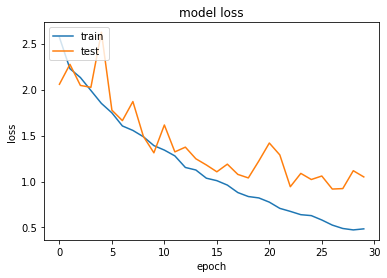

accuracy: 65.42%
30/30 - 2s - 2s/epoch - 82ms/step


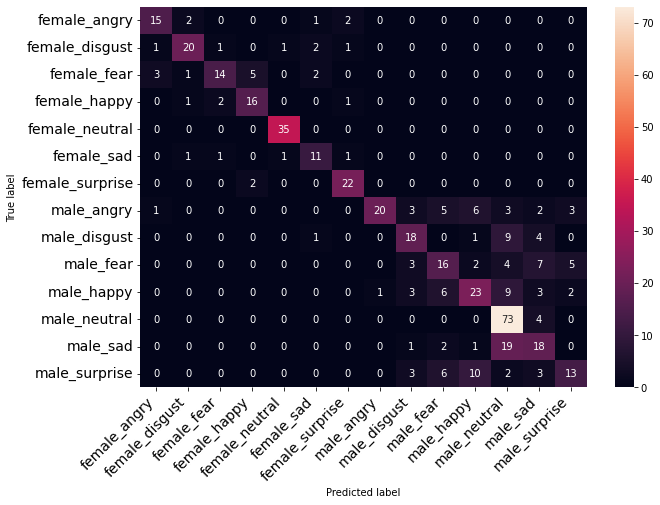

In [7]:
results = get_results(model_history,model,X_test,y_test, ref.labels.unique())
results.create_plot(model_history)
results.create_results(model)
results.confusion_results(X_test, y_test, ref.labels.unique(), model)

In [8]:
# Save model and weights
model_name = 'model_2D.h5'
save_dir = "./model/"
# save_dir = "/content/drive/My Drive/SER_project/"

# save_dir = os.path.join(os.getcwd(), 'saved_models')
# if not os.path.isdir(save_dir):
#     os.makedirs(save_dir)

model_path = save_dir + model_name
model.save(model_path)
print('Save model and weights at %s ' % model_path)

# Save the model to disk
model_json = model.to_json()
with open("./model/model_json_2D.json", "w") as json_file:
    json_file.write(model_json)
# with open("/content/drive/My Drive/SER_project/model_json.json", "w") as json_file:
#     json_file.write(model_json)

Save model and weights at ./model/model_2D.h5 


<a id="MFCCaug"></a>
## 3. MFCC with Augmentation 
Great result with using MFCC and applying a 2D CNN on it! __64% overall accuracy__, that's a huge leap from the 48% that we saw in [Part 5](https://www.kaggle.com/ejlok1/audio-emotion-part-5-data-augmentation). 

Now lets see what happens when we add in the extra step of data augmentation....

In [9]:
# sampling_rate=44100
# audio_duration=2.5
# n_mfcc = 30
# mfcc_aug = prepare_data(ref, n = n_mfcc, aug = 1, mfcc = 1)

In [10]:
# # Split between train and test 
# X_train, X_test, y_train, y_test = train_test_split(mfcc_aug
#                                                     , ref.labels
#                                                     , test_size=0.25
#                                                     , shuffle=True
#                                                     , random_state=42
#                                                    )

# # one hot encode the target 
# lb = LabelEncoder()
# y_train = np_utils.to_categorical(lb.fit_transform(y_train))
# y_test = np_utils.to_categorical(lb.fit_transform(y_test))

# # Normalization as per the standard NN process
# # mean = np.mean(X_train, axis=0)
# # std = np.std(X_train, axis=0)

# # X_train = (X_train - mean)/std
# # X_test = (X_test - mean)/std

# # Build CNN model 
# model = get_2d_conv_model(n=n_mfcc)
# model_history = model.fit(X_train, y_train, validation_data=(X_test, y_test), 
#                     batch_size=16, verbose = 2, epochs=20)

In [11]:
# results = get_results(model_history,model,X_test,y_test, ref.labels.unique())
# results.create_plot(model_history)
# results.create_results(model)
# results.confusion_results(X_test, y_test, ref.labels.unique(), model)

In [12]:
# # Save model and weights
# model_name = 'SER_Model_2D_aug.h5'
# save_dir = "./model/"
# # save_dir = "/content/drive/My Drive/SER_project/"

# # save_dir = os.path.join(os.getcwd(), 'saved_models')
# # if not os.path.isdir(save_dir):
# #     os.makedirs(save_dir)

# model_path = save_dir + model_name
# model.save(model_path)
# print('Save model and weights at %s ' % model_path)

# # Save the model to disk
# model_json = model.to_json()
# with open("./model/model_json_2D_aug.json", "w") as json_file:
#     json_file.write(model_json)
# # with open("/content/drive/My Drive/SER_project/model_json.json", "w") as json_file:
# #     json_file.write(model_json)

### 63% accuracy as well. Not too different from wihtout doing data augmentation. Slightly dissapointed the data augmentation didn't add much value, but then again I've only implemented just 1 simple version of the augmentation. Can't conclude firmly at this point if augmentation adds any value to it. Also, if augmentation is supposed to prevent overfitting (which is another topic on its own), then seeing a slight drop in accuracy is highly expected and welcomed.

<a id="final"></a>
## Final thoughts
Our advance implementation looks really good! All the 2D CNN models seems to do better than the 1D CNN model aproach that we took in previous parts of this series. In summary our accuracy from various approaches so far: 

- [1D CNN of simple MFCC mean](https://www.kaggle.com/ejlok1/audio-emotion-part-3-baseline-model) = __45%__
- [1D CNN of simple MFCC mean with data augmentation](https://www.kaggle.com/ejlok1/audio-emotion-part-5-data-augmentation) = __48%__
- [2D CNN of entire MFCC without augmentation](#MFCConly) = __64%__
- [2D CNN of entire MFCC with Augmentation](#MFCCaug) = __60%__
- [2D CNN of entire Log-melspectogram without augmentation](#logmelonly) = __63%__
- [2D CNN of entire Log-melspectogram with augmentation ](#logmelaug) = __63%__

A large improvement to the predictive accuracy was made from using the entire MFCC and log-melspectogram information, instead of just a reduced average to fit into a 1D CNN. And because we used a 2D CNN, we could take advantage of the entire information presented through the MFCC and mel-spectogram

Notice that whilst the model isn't perfect at classifying the different emotions, its done pretty well at distinguishing the genders! 

 They are a few other ideas that I have stashed them for now but if anyone's keen to try it out themselves, then here's what else you can look at: 
- Try a few other datasets (eg. EmoDB)
- Trim white noise (silence)
- Apply the other data augmentation methods
- Transfer learning from popular Image Recognition benchmarks - ResNet50 or XCEPTION or VGG19 for simplicity

We're getting close to the end of the series now so there might be two or three more left, I haven't quite decided on what to show but one of them will involve a concatenation of 2 Deep Learning networks into 1, kind of like an ensemble. it wouldn't be very Kaggle if we didn't do an ensemble right? I don't want to spoil the fun by revealing too much but it could be the next post or the post after. So stay tuned!